In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import load_excel, load_odin_as_ml_dataset, plot_confusion_matrix, make_ml_dataset, run_binary_regression, transport_modes, trip_motives

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
# Here just in case
year = 2022
odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
df = load_excel(odin_excel_path)
df = df[df["Verpl"] == 1]

Loaded file from CSV


In [3]:
print(transport_modes)

{1: 'Car - driver', 2: 'Car - passenger', 3: 'Train', 4: 'Bus/tram/metro', 5: 'Bicycle', 6: 'On foot', 7: 'Other'}


In [4]:
print(trip_motives)

{1: 'Work', 2: 'Business', 3: 'Services/personal care', 4: 'Shopping', 5: 'Education', 6: 'Visit/stay overnight', 7: 'Other social/recreational', 8: 'Touring/walking', 9: 'Other motive'}


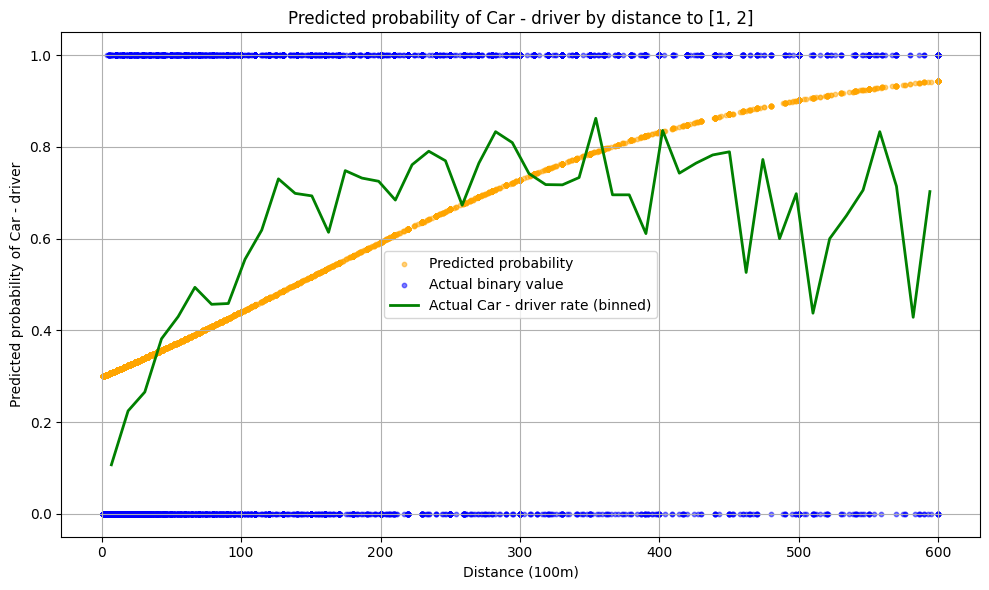

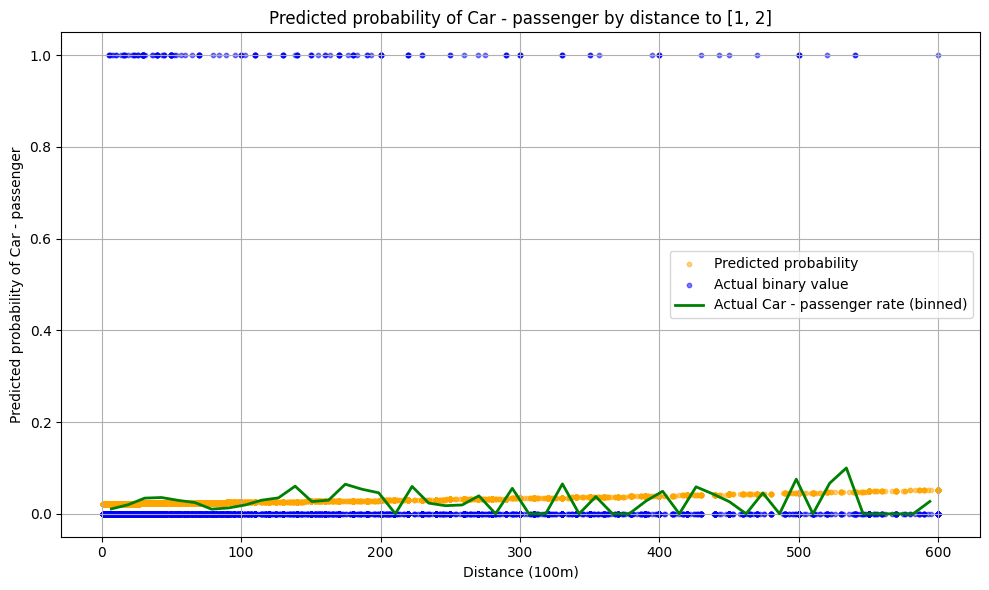

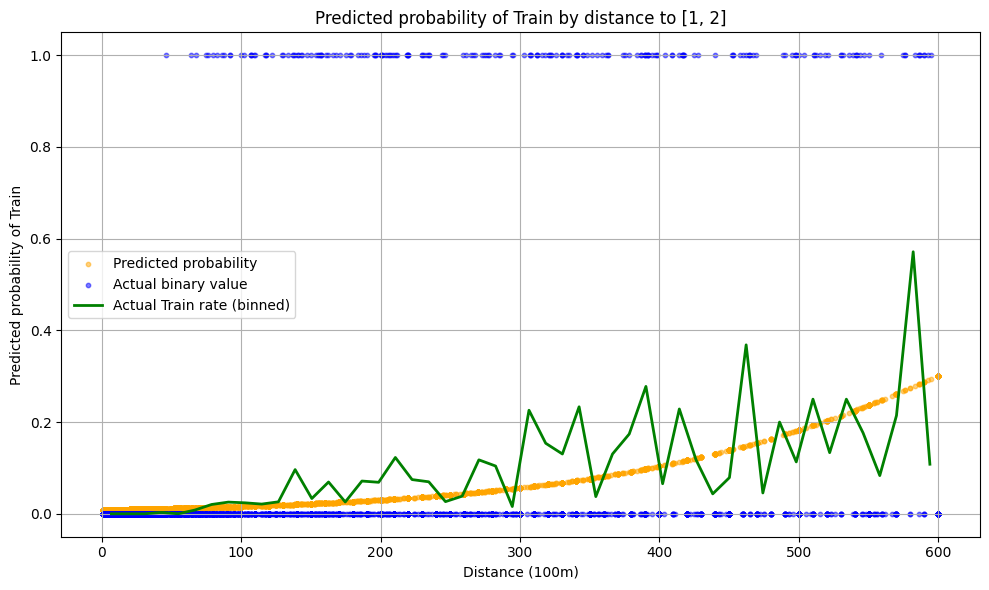

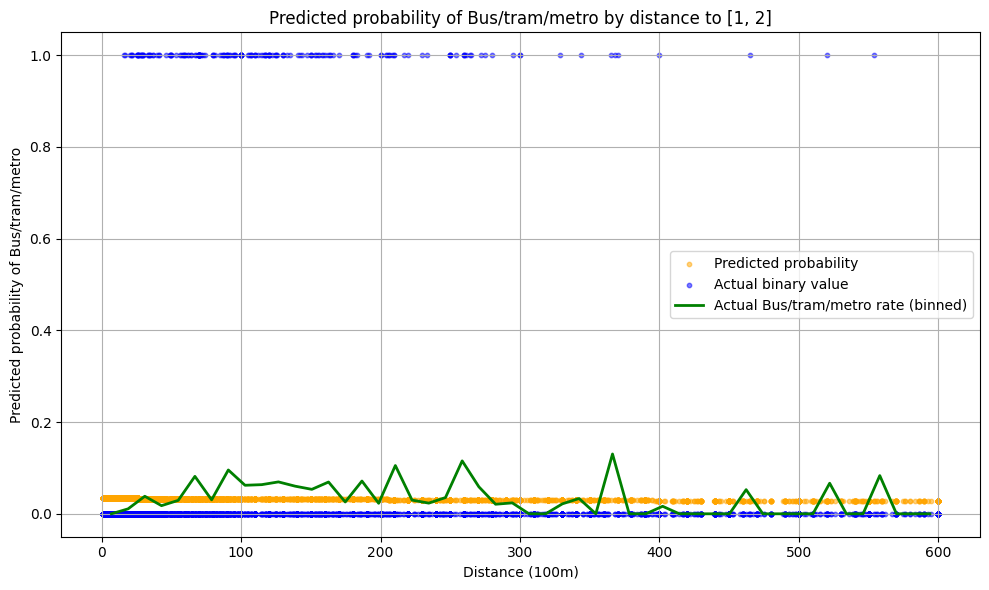

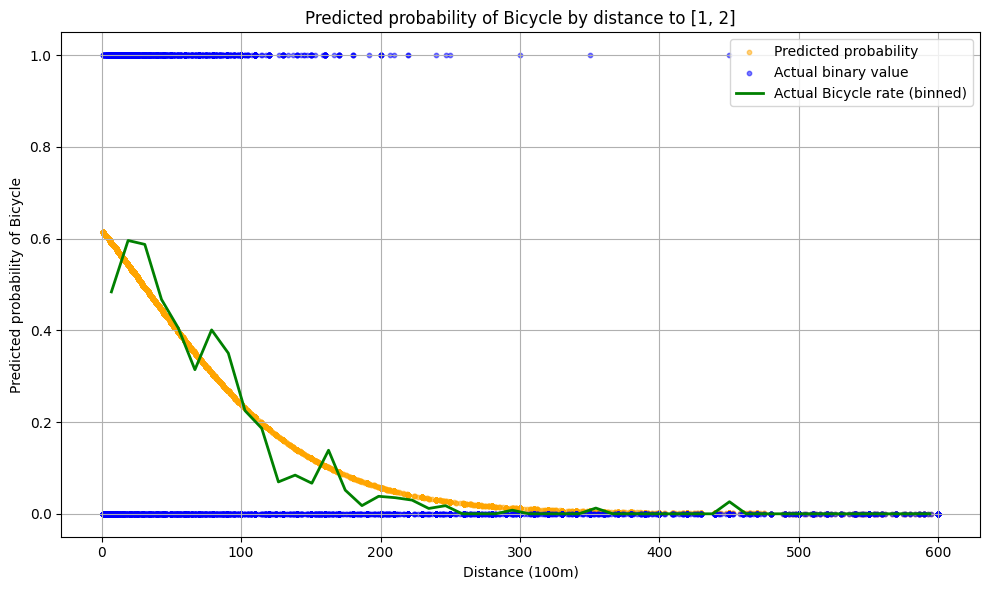

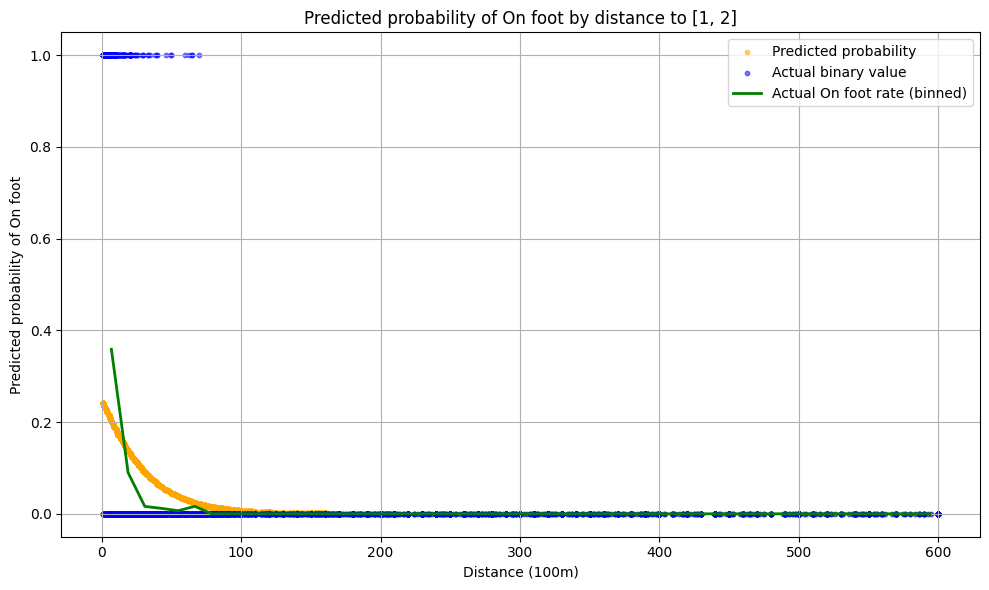

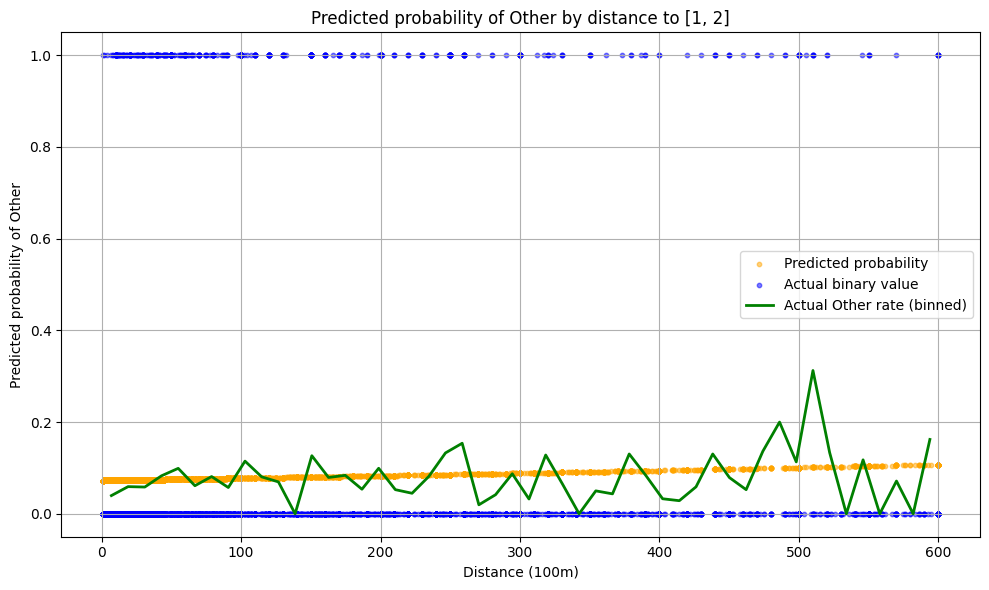

In [10]:
max_dist=600 # max distance in 100s of meters
motives=[1, 2] 

for transport_mode in transport_modes.keys():
    run_binary_regression(
        df,
        test_size=0.2,
        transport_mode=transport_mode,
        motives=motives,
        max_dist=max_dist,
        savename=f"graphics/classification_results/binary_regression/{motives}/{transport_modes[transport_mode].replace(r'/', ' or ')}_{max_dist}",
    )

Now a classifier that takes the origin and distance into account 

In [6]:
from codebase import filter_by_distance_and_duration, filter_by_origin, transport_mode_col, distance_col


def run_multiclass_classification(
        df: pd.DataFrame, 
        test_size=0.02, 
        max_dist=np.inf, 
        origins=None, 
        destinations=None,
        categorical_features=None,
        numerical_features=None,
        plot=True, 
        savename=None
        ) -> tuple:
    """

    Run a binary regression on the dataset to predict the probability of specific mode based on distance.
    The model is trained on a subset of the data where the distance is less than max_dist and the duration is not filtered.
    The model is then evaluated on a test set and the predicted probabilities are plotted against the actual values.

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe containing the data.
    transport_mode : int, optional
        The transport mode to predict. Default is 5 (Bicycle).
    test_size : float, optional
        The proportion of the dataset to include in the test split. Default is 0.02.
    max_dist : int, optional
        The maximum distance (in 100m) to filter the data. Default is 500.
    origins : list, optional
        A list of origins to filter the data. Default is None.
        If None, no filtering is applied.
    categorical_features : list, optional
        A list of categorical features to include in the model. Default is None.
    numerical_features : list, optional
        A list of numerical features to include in the model. Default is None.
    plot : bool, optional
        Whether to plot the predicted probabilities against the actual values. Default is True.
    savename : str, optional
        The name of the file to save the plot. If None, the plot will not be saved. Default is None.

    Returns
    -------
    tuple
        A tuple containing the trained model and the test set data (X_test, y_test, y_pred).
        X_train : pd.DataFrame
            The training set features.
        X_test : pd.DataFrame
            The test set features.
        y_test : pd.Series
            The actual values for the test set.
        y_pred : np.ndarray
            The predicted probabilities for the test set.
    """
    df_filtered = filter_by_distance_and_duration(df, 0, max_dist, 0, np.inf)
    df_filtered = filter_by_origin(df_filtered, origins) if origins else df_filtered
    df_filtered = filter_by_origin(df_filtered, destinations) if destinations else df_filtered

    X_train, X_test, y_train, y_test = make_ml_dataset(
        df_filtered,
        target_col=transport_mode_col,
        drop_cols=[col for col in df.columns if col not in [transport_mode_col] + 
                   (categorical_features if categorical_features is not None else []) +
                   (numerical_features if numerical_features is not None else [])],
        categorical_cols=None,
        test_size=test_size
        )

    scaler = MinMaxScaler()
    model = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10, n_estimators=100, class_weight="balanced")
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    if plot:
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, classes=transport_modes.values(), title="Confusion Matrix", savename=savename)

        print(classification_report(y_test, y_pred, target_names=transport_modes.values()))

    return pipeline, (X_train, X_test, y_test, y_pred)


In [7]:
from codebase.load_data.column_names import *

run_multiclass_classification(
    df,
    test_size=0.2,
    max_dist=max_dist,
    origins=None,
    destinations=None,
    categorical_features=[transport_mode_col, ],
    numerical_features=[distance_col, ],
    plot=True,
    savename="graphics/classification_results/multiclass_classification",
)

TypeError: plot_confusion_matrix() got an unexpected keyword argument 'classes'